## Greedy Navigation

Navigate the graph by greedily choosing the article with the smallest cosine distance to the target article.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm



In [2]:
articles_df = pd.read_feather("Data/dataframes/article_dataframe_with_embeddings.feather")
filtered_paths_df = pd.read_feather('Data/dataframes/length_filt_finished_paths.feather')
paths_df = pd.read_feather('Data/dataframes/paths.feather')

In [3]:
articles_df.head(1)

,article,article_unrendered_unicode,category,linkSource,linkTarget,distances,plain_text,incoming_links,num_hyperlinks,num_characters,hyperlink_density,embeddings
0,Áedán_mac_Gabráin,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,[subject.History.British_History.British_Histo...,Áedán_mac_Gabráin,"[Bede, Columba, Dál_Riata, Great_Britain, Irel...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...,0,11,11612,0.000947,"[-0.12923911213874817, 0.02362193539738655, -0..."


In [4]:
filtered_paths_df.head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,distance,full_path_length,simplified_path_length
0,0935d79e398bbc10,1323114272,203,Theatre;India;Bay_of_Bengal;Indian_Ocean;Afric...,NaN,True,None,Theatre,Zebra,38072,"[Theatre, India, Bay_of_Bengal, Indian_Ocean, ...","[Theatre, India, Bay_of_Bengal, Indian_Ocean, ...",3.0,8,7


In [5]:
paths_df.head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,distance,full_path_length,simplified_path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,True,None,14th_century,African_slave_trade,48,"[14th_century, 15th_century, 16th_century, Pac...","[14th_century, 15th_century, 16th_century, Pac...",3.0,8,8


### Before running this, let's do some optimizations.

In [20]:
# Store the graph, embeddings in dictionary
next_article_dict  = {}
embedding_dict  = {}

for index, row in articles_df.iterrows():
    next_article_dict[row['article']] = row['linkTarget']
    embedding_dict[row['article']] = row['embeddings']

In [ ]:
# Store the embedding distances
from sklearn.metrics.pairwise import cosine_distances

all_article_names = list(set(articles_df['article'].to_list()))
num_unique_articles = len(all_article_names)


index_lookup = {string: index for index, string in enumerate(all_article_names)}

index_lookup['Long_peper'] = index_lookup['Long_pepper']
embedding_dict['Long_peper'] = embedding_dict["Long_pepper"]
# Create a matrix to store the embeddings
embeddings_matrix = np.zeros((num_unique_articles, len(embedding_dict[all_article_names[0]])))

# Populate the embeddings matrix with the correct embeddings
for article, index in index_lookup.items():
    embeddings_matrix[index] = embedding_dict[article]

# Compute the cosine distances between all embeddings
distance_matrix = cosine_distances(embeddings_matrix)

# Function to look up the distance using the indices from index_lookup
def get_distance(article1, article2):
    index1 = index_lookup[article1]
    index2 = index_lookup[article2]
    return distance_matrix[index1, index2]

# Example usage:
# distance = get_distance("article1_name", "article2_name")


In [8]:
filtered_paths_list = []

for index, row in filtered_paths_df.iterrows():
    filtered_paths_list.append((row['start_article'], row['target_article']))


In [62]:
articles_df[articles_df['article'] == "Zebra"]['distances'].values[0]

{'10th_century': 2.0,
 '11th_century': 3.0,
 '12th_century': 3.0,
 '13th_century': 3.0,
 '14th_century': 2.0,
 '15th_Marine_Expeditionary_Unit': 4.0,
 '15th_century': 3.0,
 '16_Cygni': 6.0,
 '16_Cygni_Bb': 7.0,
 '16th_century': 3.0,
 '1755_Lisbon_earthquake': 3.0,
 '17th_century': 2.0,
 '1896_Summer_Olympics': 3.0,
 '18th_century': 2.0,
 '1928_Okeechobee_Hurricane': 4.0,
 '1973_oil_crisis': 3.0,
 '1980_eruption_of_Mount_St._Helens': 4.0,
 '1997_Pacific_hurricane_season': None,
 '19th_century': 2.0,
 '1_Ceres': 4.0,
 '1st_century': 3.0,
 '1st_century_BC': 3.0,
 '2-6-0': 5.0,
 '2-8-0': 4.0,
 '2003_Atlantic_hurricane_season': 5.0,
 '2004_Atlantic_hurricane_season': 4.0,
 '2004_Indian_Ocean_earthquake': 2.0,
 '2005_Atlantic_hurricane_season': 4.0,
 '2005_Hertfordshire_Oil_Storage_Terminal_fire': None,
 '2005_Kashmir_earthquake': 3.0,
 '2005_Lake_Tanganyika_earthquake': None,
 '2005_Sumatra_earthquake': 3.0,
 '20th_century': 2.0,
 '21st_century': 3.0,
 '2nd_century': 3.0,
 '3_Juno': 4.0,
 '

In [94]:
###  Play a list of paths with embedding lists.


def play_path_list(path_list: list[tuple]):
    # Placeholder for storing all paths
    paths_data = []
    dead_ends = 0

    dead_end_articles = set()

    # Iterate over all paths with a progress bar
    for path_start, path_end in tqdm(path_list, desc="Processing paths"):
        if not path_end in all_article_names:
            continue
        current_article = path_start
        path = [current_article]
        visited_articles = set(path)  # Keep track of visited articles

        while current_article != path_end:
            # Get the list of next articles excluding already visited ones
            next_articles = [
                article
                for article in next_article_dict[current_article]
                if article not in visited_articles
            ]

            if not next_articles:
                # If there are no unvisited next articles, break to avoid infinite loop
                # print(f"Dead-end reached from {current_article}.")
                dead_end_articles.add(current_article)
                dead_ends += 1
                break

            # Compute distances to the target for all valid next articles
            distances = [get_distance(article, path_end) for article in next_articles]
            # Find the next article with the minimum distance
            current_article = next_articles[np.argmin(distances)]
            path.append(current_article)
            visited_articles.add(current_article)  # Add the article to the visited set

        # Append path data to the list
        paths_data.append(
            {
                "start_article": path_start,
                "target_article": path_end,
                "path": path,
                "distance": articles_df[articles_df["article"] == path_start][
                    "distances"
                ].values[0][path_end],
            }
        )

    # Convert collected data to a DataFrame
    greedy_embedding_paths = pd.DataFrame(paths_data)

    print("Paths processed and stored successfully!")
    print(f"#{dead_ends} of Dead Ends")

    return greedy_embedding_paths

## Play the filtered paths

We will now "play" the filtered paths by always choosing the next article with the smallest embedding distance to the target article.

In [95]:
greedy_embedding_paths = play_path_list(filtered_paths_list)
greedy_embedding_paths['path_lengths'] = greedy_embedding_paths['path'].apply(len).apply(lambda x : x-1)

Processing paths: 100%|██████████| 21646/21646 [00:17<00:00, 1205.93it/s]

Paths processed and stored successfully!
#398 of Dead Ends


In [135]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def calculate_avg_article_weights(paths_df, count_cutoff=30, scaling=None, consider_start=True):
    """
    Calculate the average weights of articles from a DataFrame containing path information.

    Parameters:
        df (pd.DataFrame): Input DataFrame with the following columns:
            - 'path': List of articles in the path
            - 'path_lengths': Length of the simplified path
            - 'distance': Distance associated with the path
        scaling (str): Type of scaling to use. Options are 'minmax', 'standard', or None
        count_cutoff (int): Minimum number of appearances for an article to be considered
        consider_start (bool): if the start article should also receives a score 

    Returns:
        pd.DataFrame: A DataFrame containing:
            - 'article': Article name
            - 'n_appearances': Number of times the article appeared in paths
            - 'weighted_avg': Weighted average of distances for the article
    """
    # Copy and preprocess the DataFrame
    df = paths_df[['path', 'path_lengths', 'distance']].copy()

    if consider_start: 
        df['path'] = df['path'].apply(lambda l: l[:-1])  # Remove end articles
    else: 
        df['path'] = df['path'].apply(lambda l: l[1:-1]) # Remove start and end article

    # Calculate weight for each path
    df['weight'] = df['distance'] / df['path_lengths']

    # Initialize an empty DataFrame to store results
    avg_article_weight_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_avg'])
    avg_article_weight_df.set_index('article', inplace=True)

    # Iterate through each row to calculate weights
    for _, row in df.iterrows():
        weight = row['weight']
        simplified_path = row['path']

        for article in simplified_path:
            if article not in avg_article_weight_df.index:
                avg_article_weight_df.loc[article] = [0, 0.0]

            # Update counts and weighted sums
            avg_article_weight_df.at[article, 'n_appearances'] += 1
            avg_article_weight_df.at[article, 'weighted_avg'] += weight

    # Calculate the weighted average by dividing weighted sum by counts
    avg_article_weight_df['weighted_avg'] = avg_article_weight_df['weighted_avg'] / avg_article_weight_df['n_appearances']

    # Filter out articles that appear less than the cutoff
    avg_article_weight_df = avg_article_weight_df[avg_article_weight_df['n_appearances'] >= count_cutoff]

    # Normalize the weighted average
    if scaling is not None:

        if scaling == 'minmax':
            scaler = MinMaxScaler()
        elif scaling == 'standard':
            scaler = StandardScaler()

        avg_article_weight_df[scaling] = scaler.fit_transform(avg_article_weight_df[['weighted_avg']])

    #print(f"Number of unique articles after weighting: {avg_article_weight_df.shape[0]}")

    return avg_article_weight_df

In [ ]:

def calculate_sum_article_cweights(df, count_cutoff=30, scaling=None, consider_start=True):
    """
    Calculate the sum of the centered weights of articles from a DataFrame containing path information.

    Parameters:
        df (pd.DataFrame): Input DataFrame with the following columns:
            - 'path': List of articles in the path
            - 'path_lengths': Length of the simplified path
            - 'distance': Distance associated with the path
        scaling (str): Type of scaling to use. Options are 'minmax', 'standard', or None
        count_cutoff (int): Minimum number of appearances for an article to be considered
        consider_start (bool): if the start article should also receives a score 

    Returns:
        pd.DataFrame: A DataFrame containing:
            - 'article': Article name
            - 'n_appearances': Number of times the article appeared in paths
            - 'weighted_sum': sum of the centered path weights for the article
    """
    # Copy and preprocess the DataFrame
    df = df[['path', 'path_lengths', 'distance']].copy()
    # Calculate weight for each path
    df['weight'] = df['distance'] / df['path_lengths']

    if consider_start: 
        df['path'] = df['path'].apply(lambda l: l[:-1])  # Remove end articles
        # Calculate mean weight
        article_mean_weight = (df['weight'] * (df['path_lengths'])).sum() / (df['path_lengths']).sum()
    else: 
        df['path'] = df['path'].apply(lambda l: l[1:-1]) # Remove start and end article
        # Calculate mean weight
        article_mean_weight = (df['weight'] * (df['path_lengths'])-1).sum() / (df['path_lengths']-1).sum()

    # Center the weights by subtracting the mean
    df['centered_weight'] = df['weight'] - article_mean_weight

    # Initialize an empty DataFrame to store results
    sum_article_cweight_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_sum'])
    sum_article_cweight_df.set_index('article', inplace=True)

    # Iterate through each row to calculate article sum of centered weights
    for _, row in df.iterrows():
        cweight = row['centered_weight']
        simplified_path = row['path']

        for article in simplified_path:
            if article not in sum_article_cweight_df.index:
                sum_article_cweight_df.loc[article] = [0, 0.0]

            # Update counts and weighted sums
            sum_article_cweight_df.at[article, 'n_appearances'] += 1
            sum_article_cweight_df.at[article, 'weighted_sum'] += cweight

    # Filter out articles that appear less than the cutoff
    sum_article_cweight_df = sum_article_cweight_df[sum_article_cweight_df['n_appearances'] >= count_cutoff]

    # Normalize the weighted average
    if scaling is not None:

        if scaling == 'minmax':
            scaler = MinMaxScaler()
        elif scaling == 'standard':
            scaler = StandardScaler()

        sum_article_cweight_df[scaling] = scaler.fit_transform(sum_article_cweight_df[['weighted_sum']])


    #print(f"Number of unique articles after weighting: {sum_article_cweight_df.shape[0]}")

    return sum_article_cweight_df


,n_appearances,weighted_avg
article,,
Functional_programming,37.0,0.462245
Nutrition,30.0,0.436961
United_States,1433.0,0.433022
Europe,883.0,0.418325
Pythagorean_theorem,31.0,0.411703
...,...,...
Nightingale,38.0,0.011818
"George_Byron,_6th_Baron_Byron",41.0,0.010760
Richard_O'Connor,50.0,0.010285


In [ ]:
calculate_sum_article_cweights()

In [141]:

# Set the random seed for reproducibility
np.random.seed(42)
threshold = 10
# Shuffle the DataFrame
shuffled_df = greedy_embedding_paths.sample(frac=1).reset_index(drop=True)

# first downfilter start articles that have more than threshold paths
start_sampled = (
    shuffled_df.groupby('start_article')
    .head(threshold)
    .reset_index(drop=True)
)
# second downfilter target articles that have more than threshold paths
downsampled_df = (
    start_sampled.groupby('target_article')
    .head(threshold)
    .reset_index(drop=True)
)

In [ ]:
from src.utils.filtering_utils import IQR_filtering

In [153]:
IQR_filtered_greedy_paths, _ = IQR_filtering(downsampled_df, column='path_lengths')

In [154]:
avg_art_weight_df = calculate_avg_article_weights(IQR_filtered_greedy_paths)

In [156]:
avg_art_weight_df.sort_values(by="weighted_avg", ascending=False).head(10)

,n_appearances,weighted_avg
article,,
Europe,522.0,0.693240
United_States,893.0,0.680312
United_Kingdom,700.0,0.622796
Asia,271.0,0.608724
Middle_East,183.0,0.599168
Philosophy,158.0,0.588252
Lebanon,74.0,0.577414
Pollution,47.0,0.571562
China,320.0,0.568544


In [159]:
sum_art_cweights_df = calculate_sum_article_cweights(IQR_filtered_greedy_paths)

In [164]:
sum_art_cweights_df.sort_values(by="weighted_sum", ascending=False).head(20)

,n_appearances,weighted_sum
article,,
United_States,893.0,293.066200
United_Kingdom,700.0,189.466245
Europe,522.0,178.059526
Africa,798.0,172.621368
France,608.0,111.899011
Germany,497.0,106.198051
Russia,451.0,90.130194
Japan,443.0,80.793198
Earth,627.0,80.263498


In [ ]:
greedy_embedding_paths['distance'].describe()

In [65]:
greedy_embedding_paths.head(1)

,start_article,target_article,path,min_distance,path_lengths
0,Theatre,Zebra,"[Theatre, Music, Sound, Bat, Animal, Fish, Dol...",3.0,9


In [11]:
greedy_embedding_paths['path_lengths'].describe()

count    21646.000000
mean        29.556823
std         91.623987
min          2.000000
25%          4.000000
50%          6.000000
75%         14.000000
max       1279.000000
Name: path_lengths, dtype: float64

In [133]:
greedy_embedding_paths[greedy_embedding_paths['distance']==5]['path_lengths'].describe()

count     263.000000
mean      138.365019
std       226.790879
min         5.000000
25%         9.000000
50%        22.000000
75%       152.500000
max      1143.000000
Name: path_lengths, dtype: float64

(array([ 336., 2139., 3386., 2915., 2108., 1355., 1100.,  832.,  650.,
         546.,  443.,  394.,  348.,  307.,  187.,  212.,  201.,  171.,
         134.,  151.,  117.,  106.,  112.,   96.,   67.,   84.,   90.,
          91.]),
 array([ 2.        ,  2.96428571,  3.92857143,  4.89285714,  5.85714286,
         6.82142857,  7.78571429,  8.75      ,  9.71428571, 10.67857143,
        11.64285714, 12.60714286, 13.57142857, 14.53571429, 15.5       ,
        16.46428571, 17.42857143, 18.39285714, 19.35714286, 20.32142857,
        21.28571429, 22.25      , 23.21428571, 24.17857143, 25.14285714,
        26.10714286, 27.07142857, 28.03571429, 29.        ]),
 <BarContainer object of 28 artists>)

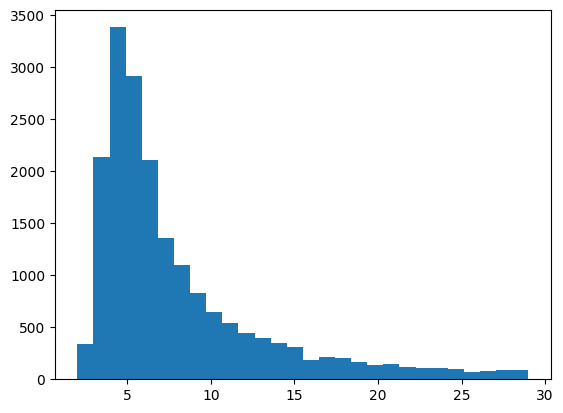

In [12]:
import matplotlib.pyplot as plt
greedy_embedding_paths_filtered = greedy_embedding_paths[greedy_embedding_paths['path_lengths'] < 30]
plt.hist(greedy_embedding_paths_filtered['path_lengths'], bins=28)

In [13]:
# Make sure the size is the same
filtered_paths_df['full_path_length'] = filtered_paths_df['full_path_length'].apply(lambda x : x+1)
filtered_paths_df['full_path_length'].describe()

count    21646.000000
mean         5.856786
std          1.985092
min          2.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         17.000000
Name: full_path_length, dtype: float64

(array([1745., 3988., 8988., 2822., 2963.,  696.,  331.,   92.,   12.,
           9.]),
 array([ 2. ,  3.5,  5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. , 15.5, 17. ]),
 <BarContainer object of 10 artists>)

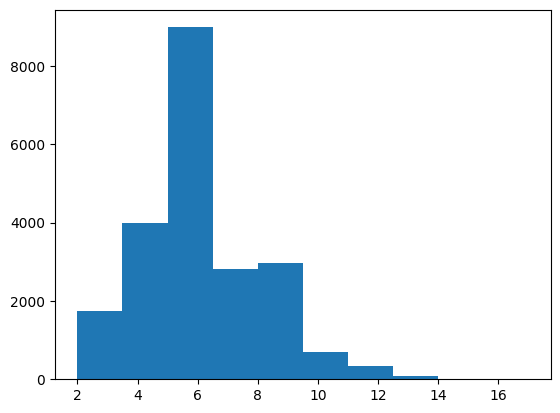

In [14]:
plt.hist(filtered_paths_df['full_path_length'])

# Play the Unfiltered Paths

In [15]:
unfiltered_paths_list = [] 

for index, row in paths_df.iterrows():
    unfiltered_paths_list.append((row['start_article'], row['target_article']))


In [103]:
greedy_all_paths = play_path_list(unfiltered_paths_list)

Processing paths: 100%|██████████| 76193/76193 [01:09<00:00, 1094.19it/s]

Paths processed and stored successfully!
#2604 of Dead Ends


In [104]:
greedy_all_paths['path_lengths'] = greedy_all_paths['path'].apply(len).apply(lambda x : x-1)

In [105]:
greedy_all_paths['path_lengths'].describe()

count    76165.000000
mean        39.842565
std        120.538922
min          0.000000
25%          4.000000
50%          6.000000
75%         14.000000
max       1456.000000
Name: path_lengths, dtype: float64

In [47]:
greedy_all_paths.head(1)

,start_article,target_article,path,path_lengths
0,14th_century,African_slave_trade,"[14th_century, Niger, African_Union, Economy_o...",5


In [106]:

# Set the random seed for reproducibility
np.random.seed(42)
threshold = 10
# Shuffle the DataFrame
shuffled_df = greedy_all_paths.sample(frac=1).reset_index(drop=True)

# first downfilter start articles that have more than threshold paths
start_sampled = (
    shuffled_df.groupby('start_article')
    .head(threshold)
    .reset_index(drop=True)
)
# second downfilter target articles that have more than threshold paths
downsampled_df = (
    start_sampled.groupby('target_article')
    .head(threshold)
    .reset_index(drop=True)
)

In [114]:
downsampled_df['path_lengths'].describe()

count    26992.000000
mean        50.107624
std        137.086505
min          0.000000
25%          4.000000
50%          7.000000
75%         20.000000
max       1456.000000
Name: path_lengths, dtype: float64

In [128]:
downsampled_df[downsampled_df['distance'] == 2]['path_lengths'].describe()

count    5439.000000
mean       11.212355
std        43.363814
min         2.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       911.000000
Name: path_lengths, dtype: float64

In [112]:
# Apply IQR filtering on 'path_lengths' with distance as lower bound
filtered_df, removed_count = IQR_filtering(downsampled_df, column='path_lengths', lower_bound=False)

print("Filtered DataFrame:")
print(filtered_df)

print(f"Rows removed: {removed_count}")


Filtered DataFrame:
        start_article  target_article  \
0             Cricket           Deity   
1            Asteroid          Viking   
2         Isaac_Brock             Pea   
3           Aristotle            Food   
4            Asteroid          Viking   
...               ...             ...   
23255      Snow_Goose      Snow_Goose   
23256  American_Samoa  American_Samoa   
23257      Royal_Navy      Royal_Navy   
23258     Abel_Tasman     Abel_Tasman   
23259         Lesotho         Lesotho   

                                                    path  distance  \
0        [Cricket, India, Christianity, Religion, Deity]       3.0   
1           [Asteroid, Dinosaur, Turtle, Canada, Viking]       3.0   
2      [Isaac_Brock, University, Latin, Bible, God, D...       3.0   
3      [Aristotle, Education, Computer, Television, S...       3.0   
4           [Asteroid, Dinosaur, Turtle, Canada, Viking]       3.0   
...                                                  ...       ... 